# **2 - LSTM (*Long Short-Term Memory*)**

# Introduction

LSTM or Long Short-Term Memory networks are a type of sequential neural network designed to avoid the main problems of RNNs, which are the vanishing and exploding gradient descent problems, as we already mentioned in `1-RNN.ipynb`. This means that LSTMs can learn long-term dependencies in the data (in other words, can use longer sequences of data). This is achieved using separate paths for Long-Term memories and Short-Term memories, as is shown in the following image, which represents the structure of an LSTM cell:

<p align="left">
<img src="https://miro.medium.com/v2/resize:fit:1156/1*laH0_xXEkFE0lKJu54gkFQ.png"/>
</p>

*Figure 1: [Understanding LSTM and its diagrams](https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714), Shi Yan*

LSTMs introduce three main concepts:

- **Forget Gate**: this gate controls how much information from previous cells to remember.
- **Input gate**: quantifies the importance of the new information added by the input.
- **Output gate**: controls how much information from the current cell to output to the next cell.

Additionally, LSTMs use two types of activation functions (as can be seen in the image above):

- **Sigmoid**
- **Tanh**

**Source**: [Learn About Long Short-Term Memory (LSTM) Algorithms](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/), Analytics Vidhya

Let's load the required libraries in order to run the code:

In [1]:
import os

import pandas as pd
import numpy as np
# import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_preprocessing import train_test_split, tokenization
from src.utils import plot_metric_curves

## Load dataset

Let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and test sets

We need to generate both training and test sets. We will use 80% of the data for training and the remaining 20% for testing. Moreover, in classification tasks it is important to maintain the same proportion of classes in both training and test sets (otherwise, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_preprocessing.py`:

In [3]:
X_train, y_train, X_test, y_test = train_test_split(df, "label")

Let's check that the training set contains 80% of data:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also check that the distribution of classes in both sets are almost the same:

In [5]:
y_train.value_counts(normalize=True)

0    0.518145
1    0.481855
Name: label, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.518237
1    0.481763
Name: label, dtype: float64

# Tokenization, Padding and Sequencing

As mentioned in the previous notebook, we need to tokenize the text before feeding the data into our model. For doing so, we will apply the function `tokenization` from `src/data_preprocessing.py` we have developed:

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, test_padded, max_seq_len, vocab_size = tokenization(tokenizer, X_train, X_test, "headline") 

## Build the model

We will use Bidirectional LSTMs, which differ from the standard LSTMs in that they have two hidden layers, one for the forward pass and one for the backward pass. This means the input flows in both directions, forward and backward, through the network. This helps the Bidirectional LSTMs to produce a more meaningful output. For instance, given the following sentences:

> *Apples can be red, green or yellow.*

> *Apple will release the new iPhone soon.*

Standard LSTMs models will not know what `Apple` means in each sentence, since these models do not know the context from future words. On the other hand, Bidirectional LSTMs will be able to understand that `Apple` in the first sentence refers to the fruit, and `Apple` in the second sentence refers to the company, resulting in more accurate predictions.

<p align="left">
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2022/01/bilstm-1-1024x384.png"/>
</p>

*Figure 2: [Differences Between Bidirectional and Unidirectional LSTM](https://blog.mlreview.com/understanding-lstm-and-its-diagrams-37e2f46f1714), Baeldung*

In [8]:
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_len))

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 50)            383550    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

## Train the model

Let's first create a folder where to save our models.

In [11]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [12]:
# Model name and path
model_path = os.path.join("models", "lstm_model.h5")

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no improvement in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs, as we can be fairly sure that training will be stopped before reaching the limit.

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [14]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(test_padded, np.array(y_test)),
    callbacks = [es, mc]
)

Epoch 1/30
337/338 [============================>.] - ETA: 0s - loss: 0.5041 - acc: 0.7416
Epoch 1: val_loss improved from inf to 0.42793, saving model to models\lstm_model.h5
338/338 [==============================] - 14s 31ms/step - loss: 0.5039 - acc: 0.7416 - val_loss: 0.4279 - val_acc: 0.8002
Epoch 2/30
337/338 [============================>.] - ETA: 0s - loss: 0.3219 - acc: 0.8610
Epoch 2: val_loss improved from 0.42793 to 0.42009, saving model to models\lstm_model.h5
338/338 [==============================] - 11s 34ms/step - loss: 0.3221 - acc: 0.8609 - val_loss: 0.4201 - val_acc: 0.8034
Epoch 3/30
337/338 [============================>.] - ETA: 0s - loss: 0.2379 - acc: 0.9019
Epoch 3: val_loss did not improve from 0.42009
338/338 [==============================] - 11s 34ms/step - loss: 0.2377 - acc: 0.9020 - val_loss: 0.4853 - val_acc: 0.7941
Epoch 4/30
337/338 [============================>.] - ETA: 0s - loss: 0.1791 - acc: 0.9296
Epoch 4: val_loss did not improve from 0.42009

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

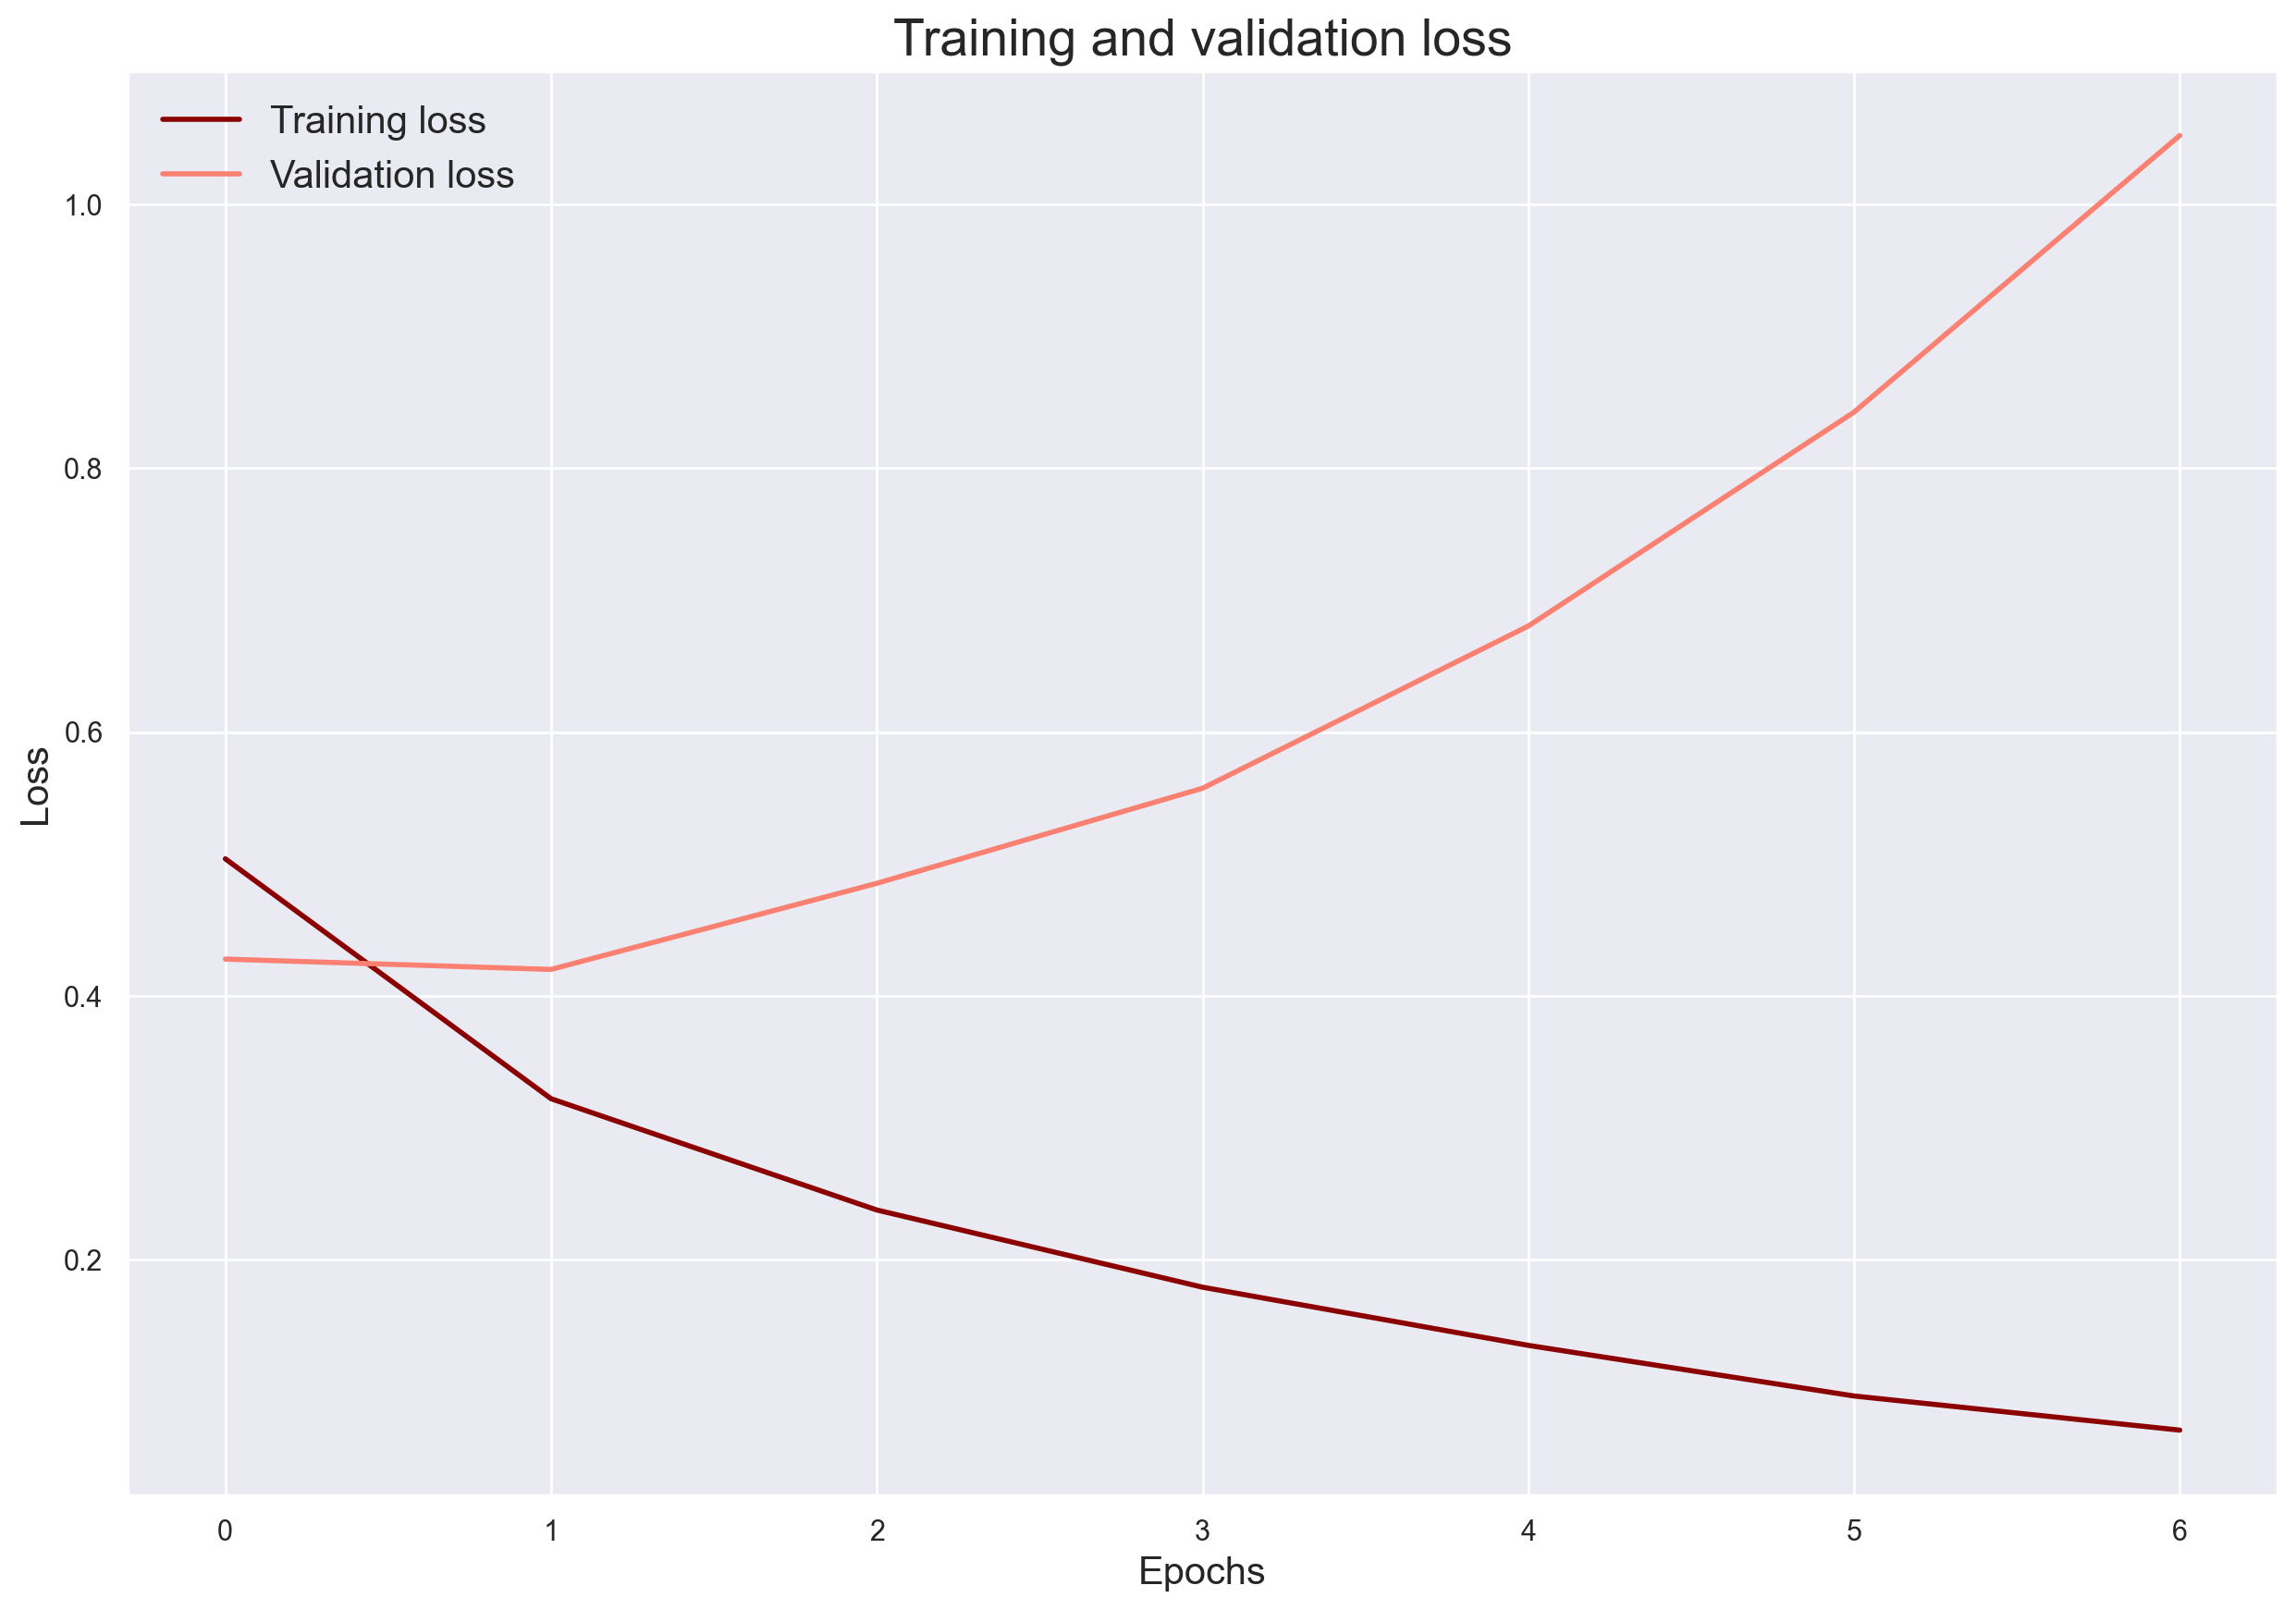

In [16]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss")

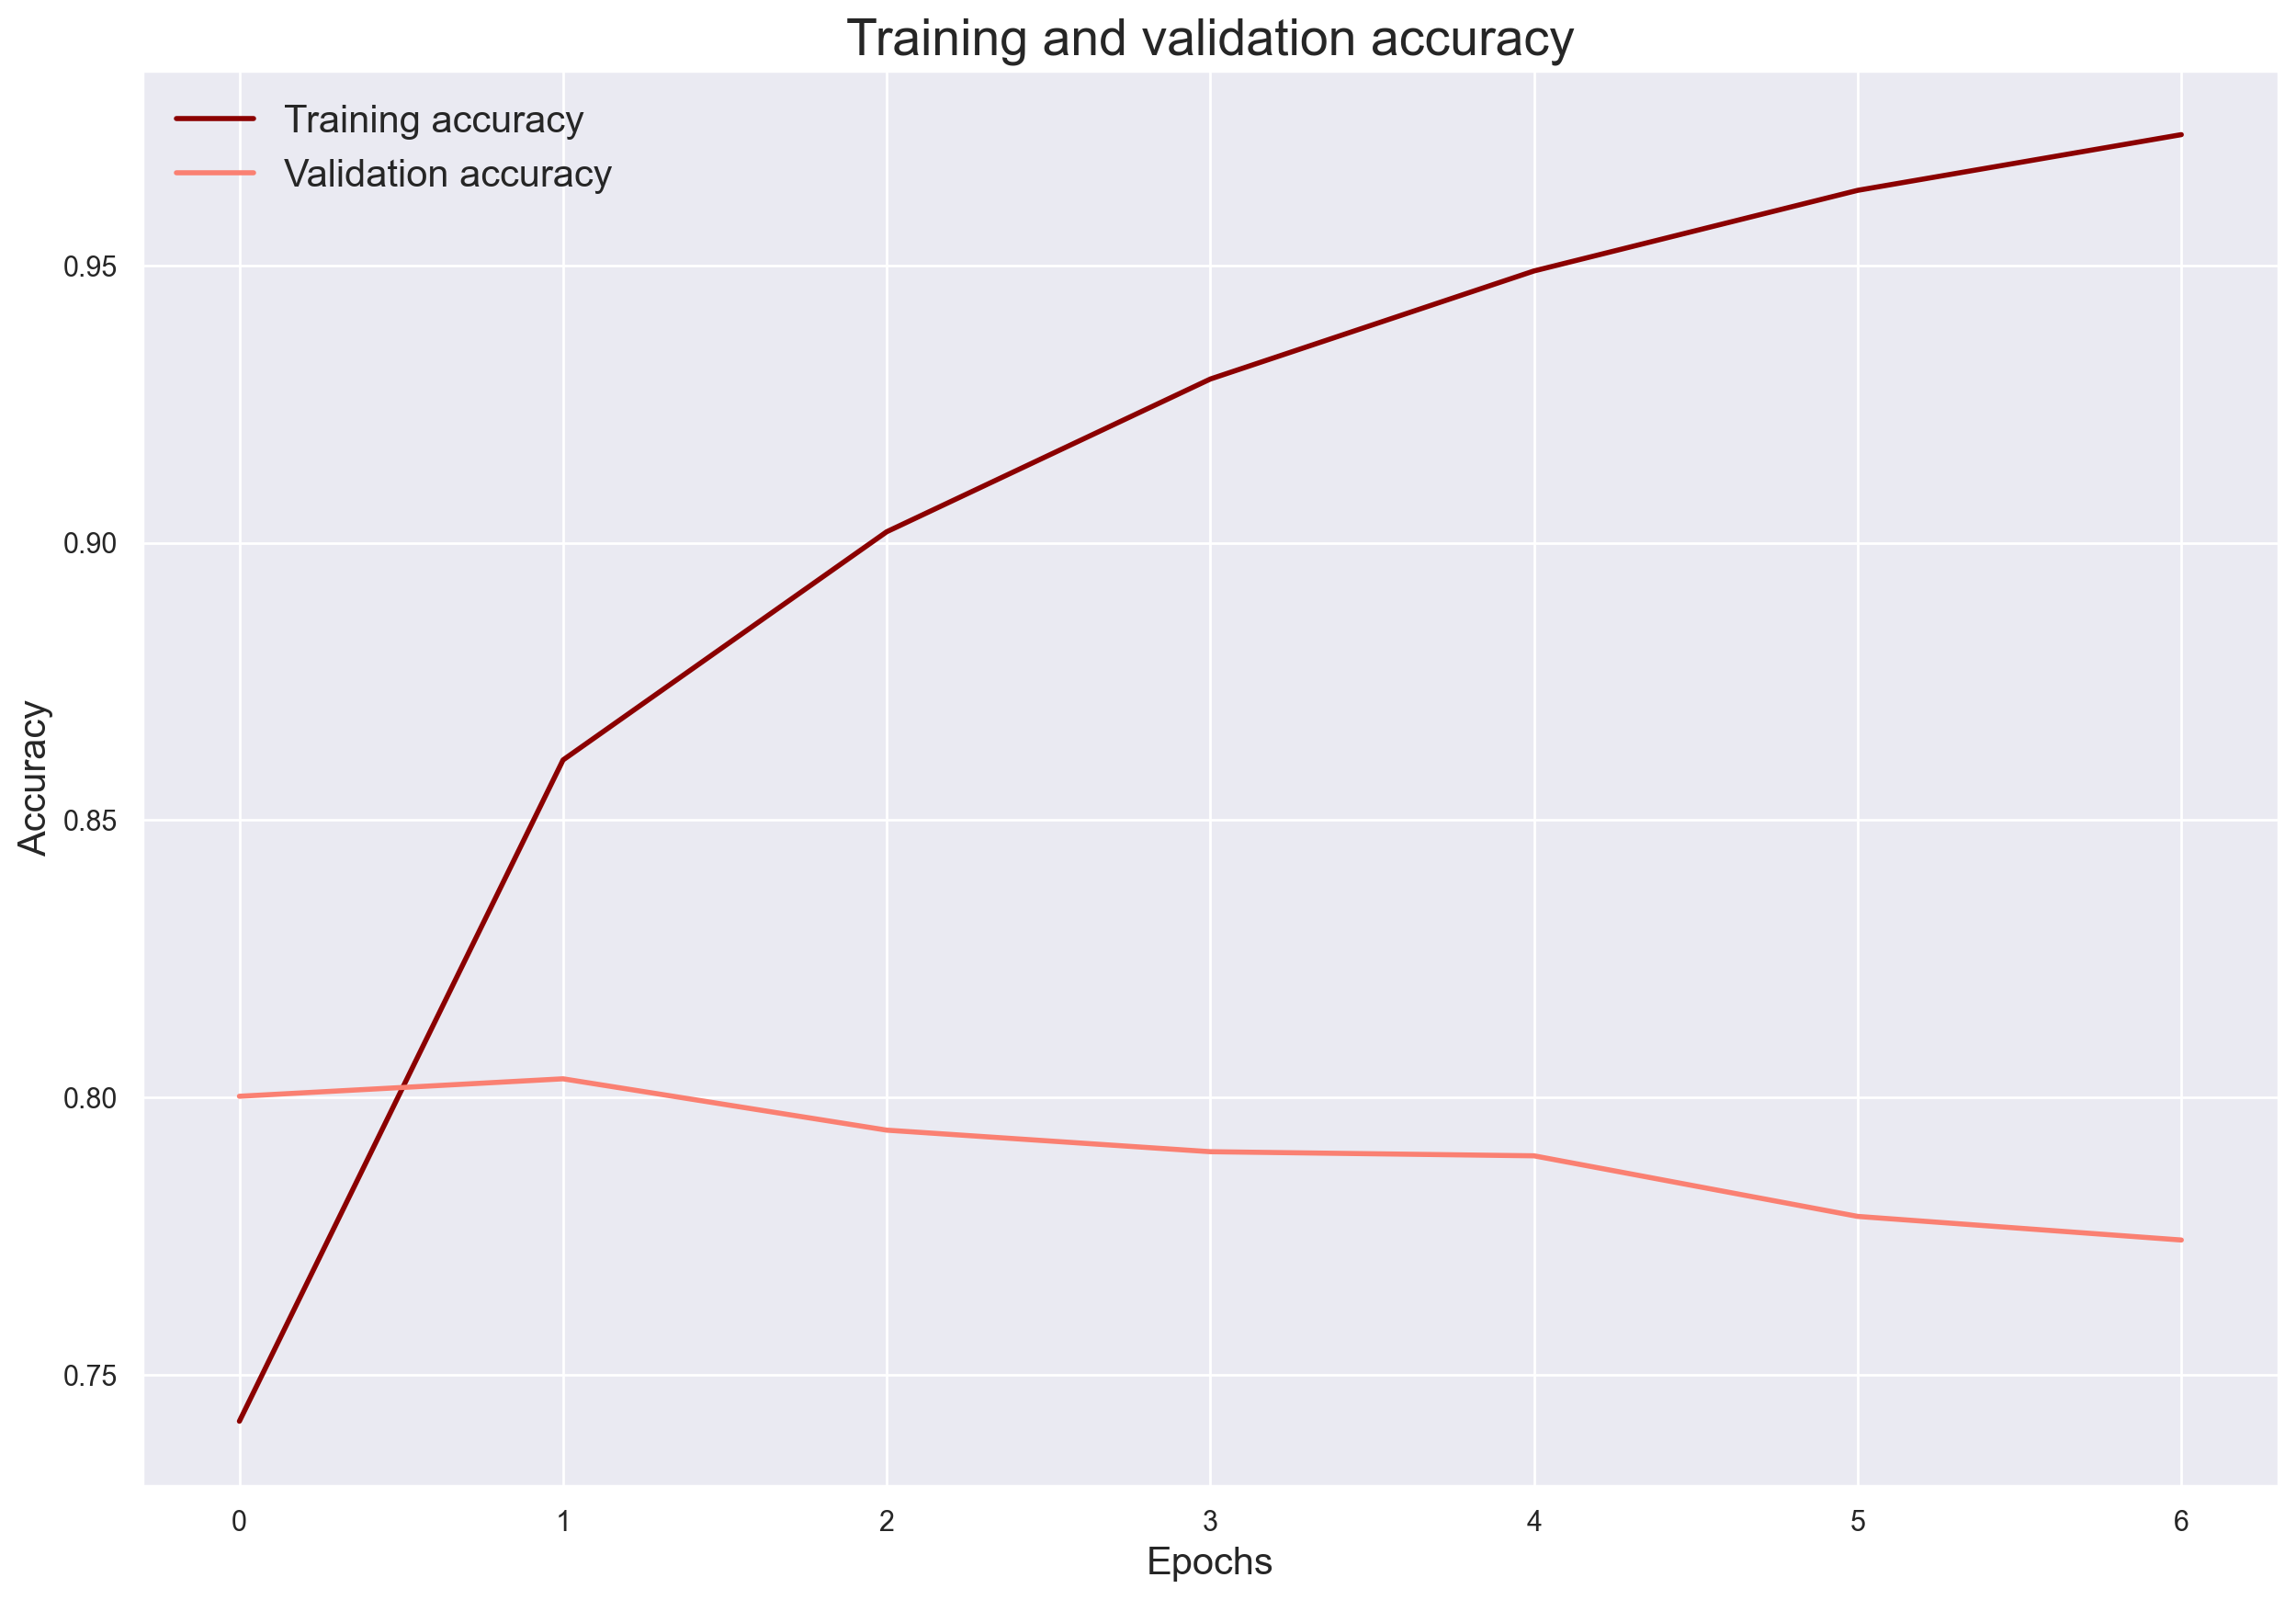

In [17]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "Accuracy")

*Comment results obtained*